<font size="+2"><strong>1. Property Data Analysis</strong></font>

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

<font size="+2"><strong>1.1. Location or Size: What Influences House Prices?</strong></font>

# Prepare Data

## Import

In [119]:
#wrangle function
def wrangle(filename):

    #read csv file
    df = pd.read_csv(filename)

    #dOnly residential property
    df = df[(df['PropType'] == 'Residential') & (df['Sale_price'] >= 80000) & (df['Sale_price'] <= 400000)] 
    
    #drop null columns with more than 400 missing 
    df.dropna(thresh = df.shape[0] -  400, axis = 1, inplace = True)

    #drop any null rows
    df.dropna(axis = 0, inplace = True)
    
    # drop some columns with high cardinality 
    df.drop(columns = ['Sale_date', 'Address'], inplace = True)
    
    #manipulate high cardinality features
    top_10_style = df['Style'].value_counts().head(9).keys().tolist()
    df['Style'] = df['Style'].apply(lambda x : x if x in top_10_style else 'Other')

    #we will drop some columns with low cardinality
    df.drop(columns = ['Units', 'Hbath', 'Fbath'], inplace = True)

    # dropping stuffs
    df.drop(columns = ['Nbhd', 'Taxkey', 'Year_Built', 'Nr_of_rms', 'Bdrms', 'Lotsize'], inplace = True)

    df['Price_per_sqft'] = round(df['Sale_price'] / df['FinishedSqft'])

    # outliers df for feet
    q1_f, q3_f = (df["FinishedSqft"].quantile([0.1,0.9]))
    outlier_ft = df['FinishedSqft'].between(q1_f, q3_f)

    #outlier price, only (210,000 and 357,000)
    q1_p, q3_p = (df["Sale_price"].quantile([0.1, 0.9]))
    outlier_price = df['Sale_price'].between(q1_p, q3_p)

    df = df[outlier_ft & outlier_price]
    return df

In [121]:
df = wrangle('property_one.csv')

In [123]:
print(f' Total Null values: {df.isnull().sum().sum()}')
print(f" Shape of the df : {df.shape[0]} rows and {df.shape[1]} columns")
print(f" Dataframe size is : {df.size} datasets ")
df.head()

 Total Null values: 0
 Shape of the df : 13412 rows and 8 columns
 Dataframe size is : 107296 datasets 


,PropType,District,Style,Extwall,Stories,FinishedSqft,Sale_price,Price_per_sqft
51,Residential,3,Other,Frame,2.0,1992,145000,73.0
358,Residential,1,Cape Cod,Brick,1.0,1620,148500,92.0
359,Residential,13,Ranch,Brick,1.0,986,105000,106.0
1277,Residential,8,Other,Aluminum / Vinyl,1.5,2091,155000,74.0
1849,Residential,1,Cape Cod,Stone,1.0,1188,103000,87.0


In [125]:
#high cardinality features
df.select_dtypes('object').nunique()

PropType     1
Style       10
Extwall      9
dtype: int64

In [127]:
df.describe()

,District,Stories,FinishedSqft,Sale_price,Price_per_sqft
count,13412.000000,13412.000000,13412.000000,13412.000000,13412.000000
mean,9.295929,1.222152,1391.851775,143955.954518,107.069937
std,3.738133,0.368221,326.659280,30295.147435,25.666570
min,1.000000,1.000000,954.000000,94500.000000,42.000000
25%,5.000000,1.000000,1131.000000,120000.000000,90.000000
50%,10.000000,1.000000,1306.500000,140000.000000,107.000000
75%,13.000000,1.500000,1600.000000,164000.000000,124.000000
max,15.000000,3.000000,2252.000000,220000.000000,210.000000


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13412 entries, 51 to 34440
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PropType        13412 non-null  object 
 1   District        13412 non-null  int64  
 2   Style           13412 non-null  object 
 3   Extwall         13412 non-null  object 
 4   Stories         13412 non-null  float64
 5   FinishedSqft    13412 non-null  int64  
 6   Sale_price      13412 non-null  int64  
 7   Price_per_sqft  13412 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 943.0+ KB


In [131]:
df.select_dtypes('number').nunique()

District            15
Stories              5
FinishedSqft      1279
Sale_price        1102
Price_per_sqft     158
dtype: int64

## Explore

**Let us look at the distribution of Sale prices**

In [135]:
df.head()

,PropType,District,Style,Extwall,Stories,FinishedSqft,Sale_price,Price_per_sqft
51,Residential,3,Other,Frame,2.0,1992,145000,73.0
358,Residential,1,Cape Cod,Brick,1.0,1620,148500,92.0
359,Residential,13,Ranch,Brick,1.0,986,105000,106.0
1277,Residential,8,Other,Aluminum / Vinyl,1.5,2091,155000,74.0
1849,Residential,1,Cape Cod,Stone,1.0,1188,103000,87.0


<Axes: xlabel='District', ylabel='Values'>

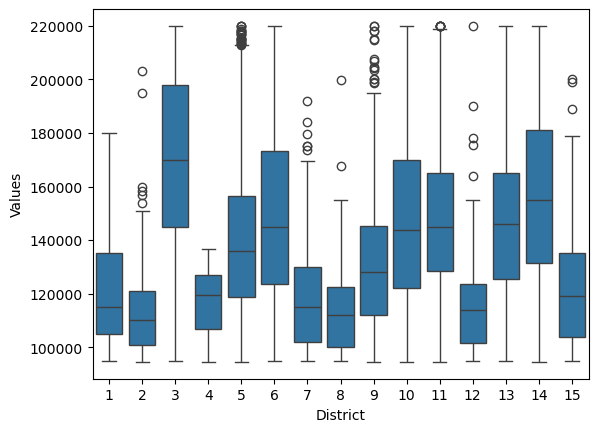

In [137]:
# we want to look at the distribution of sales prices
melted_df = pd.melt(df, id_vars = 'District', value_vars = 'Sale_price', value_name = 'Values', var_name = 'Features')
sns.boxplot(x = 'District', y = 'Values', data = melted_df );

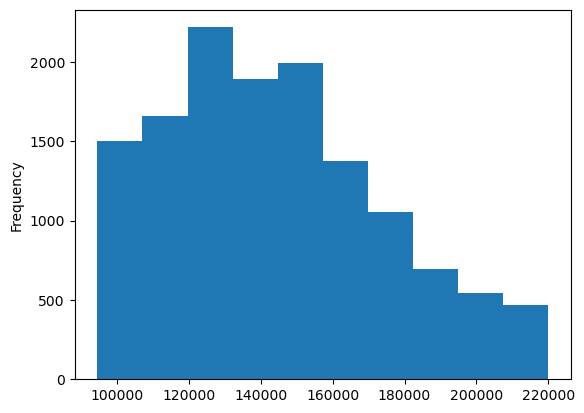

In [139]:
df['Sale_price'].plot(kind = 'hist');

# we have lots of outlier prices, we should remove them or focus on buildings less than 400000

**Which District has the most expensive real estate market?**

In [142]:
mean_price_by_district = df.groupby('District')['Price_per_sqft'].mean().reset_index(name = 'Mean_price').sort_values(by = 'Mean_price', ascending = False)
mean_price_by_district.head()

,District,Mean_price
10,11,116.173601
13,14,114.465328
12,13,113.192138
2,3,109.459410
4,5,107.111519


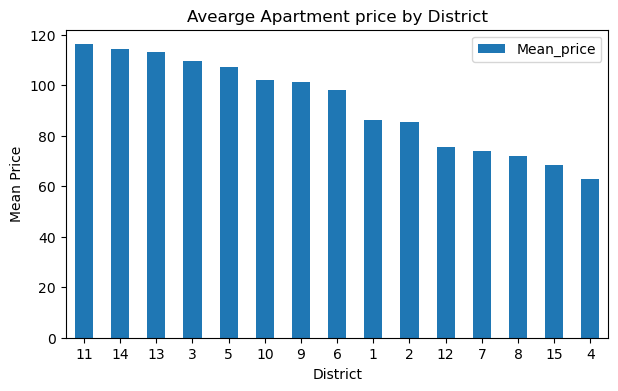

In [144]:
mean_price_by_district.plot(kind = 'bar', x = 'District', y = 'Mean_price', rot = 0, figsize = (7,4))
plt.xlabel('District')
plt.ylabel('Mean Price')
plt.title('Avearge Apartment price by District');

**Is there a relationship between home size and price?**

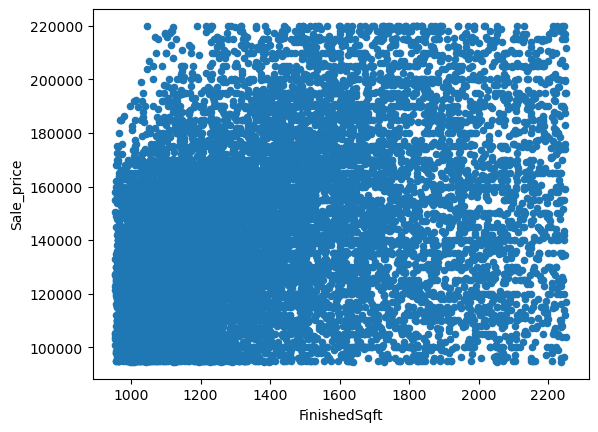

In [147]:
df.plot(kind = 'scatter', x = 'FinishedSqft', y = 'Sale_price');

In [149]:
corr_mat = df.select_dtypes('number').corr()

In [421]:
corr_mat['Sale_price'].sort_values(ascending = False)

# finishedSqft has a very low correlation with sale price, but for this activity, we will continue and build a model anyways
# there are other factors that affect price of a building

Sale_price        1.000000
Price_per_sqft    0.534111
FinishedSqft      0.316821
Stories           0.201674
District          0.172189
Name: Sale_price, dtype: float64

<font size="+2"><strong>1.2. Predicting Price with FinishedSqft</strong></font>

## Split

In [425]:
X = df[['FinishedSqft']]
y = df['Sale_price']

cutoff = int(len(df)*0.8)

X_train, y_train, X_test, y_test = (X.iloc[: cutoff], y.iloc[:cutoff], X.iloc[cutoff:], y.iloc[cutoff:] )

print(f" X_train length: {X_train.shape[0]}")
print(f" X_test length: {X_test.shape[0]}")
print(f" y_train length: {y_train.shape[0]}")
print(f" y_test length: {y_test.shape[0]}")

 X_train length: 10729
 X_test length: 2683
 y_train length: 10729
 y_test length: 2683


## Build Model

### Baseline

In [429]:
y_pred_baseline = [y_train.mean()]* len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print(f"Residential mean price: {round(y_train.mean())}")
print(f"Mae_baseline: {round(mae_baseline)}")

Residential mean price: 142221
Mae_baseline: 24421


### Iterate

In [432]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [434]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)

print(f" mae_training : {round(mae_training)}")

 mae_training : 22823


In [436]:
y_pred_test = model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f" mae_test: {round(mae_test)}")

 mae_test: 25258


## Communication

In [439]:
intercept = round(model.intercept_)
coefficient = round(model.coef_[0])

print(f"Residenial_price = {intercept} + {coefficient} * FinishedSqft")

Residenial_price = 99438 + 31 * FinishedSqft
